In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [5]:
train_path = r"C:\Users\aparn\Downloads\archive (4)\fashion-mnist_train.csv"
test_path  = r"C:\Users\aparn\Downloads\archive (4)\fashion-mnist_test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train = train_df.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0
y_test = test_df.iloc[:, 0].values


In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [7]:
dataset = TensorDataset(X_train, y_train)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")


Epoch 1/5, Loss: 402.2977
Epoch 2/5, Loss: 244.0630
Epoch 3/5, Loss: 207.1907
Epoch 4/5, Loss: 184.3193
Epoch 5/5, Loss: 164.6455


In [11]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)


In [12]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))



Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1000
           1       0.98      0.99      0.98      1000
           2       0.88      0.85      0.87      1000
           3       0.90      0.92      0.91      1000
           4       0.81      0.91      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.83      0.65      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.99      0.98      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



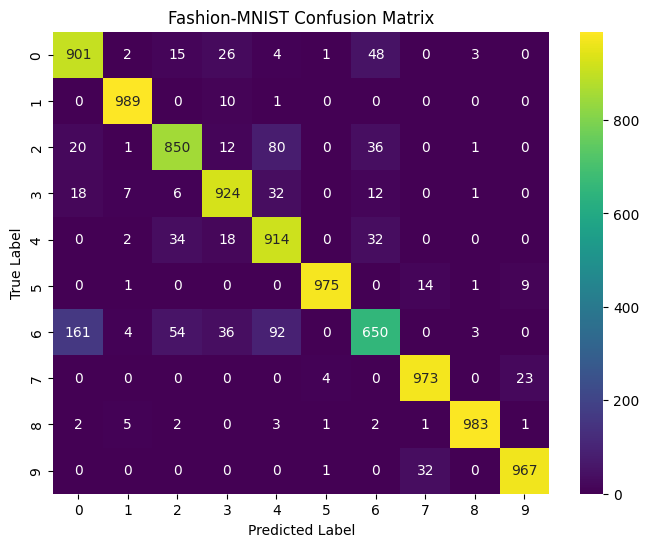

In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Fashion-MNIST Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
